In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Importing essential libraries
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
import random
import cv2  # For image handling
from collections import defaultdict

In [13]:
# Check for GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
  try:
    for device in physical_devices:
      tf.config.experimental.set_memory_growth(device, True)
    tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')
    print('GPU is available')
  except RuntimeError as e:
    print(e)
else:
  strategy = tf.distribute.get_strategy()
  print('Number of replicas:', strategy.num_replicas_in_sync)


Number of replicas: 1


In [14]:
#import zipfile

# Define the path to your zip file
#file_path = '/content/drive/MyDrive/data/archive (1).zip'

# Unzip the file to a specific destination
# zipfile.ZipFile(file_path, 'r') as zip_ref:
  #zip_ref.extractall('/content/drive/MyDrive/data')

In [15]:
# Define the data path
data_path = '/content/drive/MyDrive/data/leapGestRecog'

Starting data analysis...

Counting images in each subfolder...
Image count in subfolders completed.

Image Counts in Each Subfolder (Class):
01_palm: 200 images
02_l: 200 images
03_fist: 200 images
04_fist_moved: 200 images
05_thumb: 200 images
06_index: 200 images
07_ok: 200 images
08_palm_moved: 200 images
09_c: 200 images
10_down: 200 images
Checking image sizes across subfolders...
Image size check completed.


Image Sizes in Each Subfolder:
01_palm: {(240, 640, 3)}
02_l: {(240, 640, 3)}
03_fist: {(240, 640, 3)}
04_fist_moved: {(240, 640, 3)}
05_thumb: {(240, 640, 3)}
06_index: {(240, 640, 3)}
07_ok: {(240, 640, 3)}
08_palm_moved: {(240, 640, 3)}
09_c: {(240, 640, 3)}
10_down: {(240, 640, 3)}
Checking image data types...
Image dtype check completed.


Image Data Types: {dtype('uint8')}
Displaying 3 random images from each class...


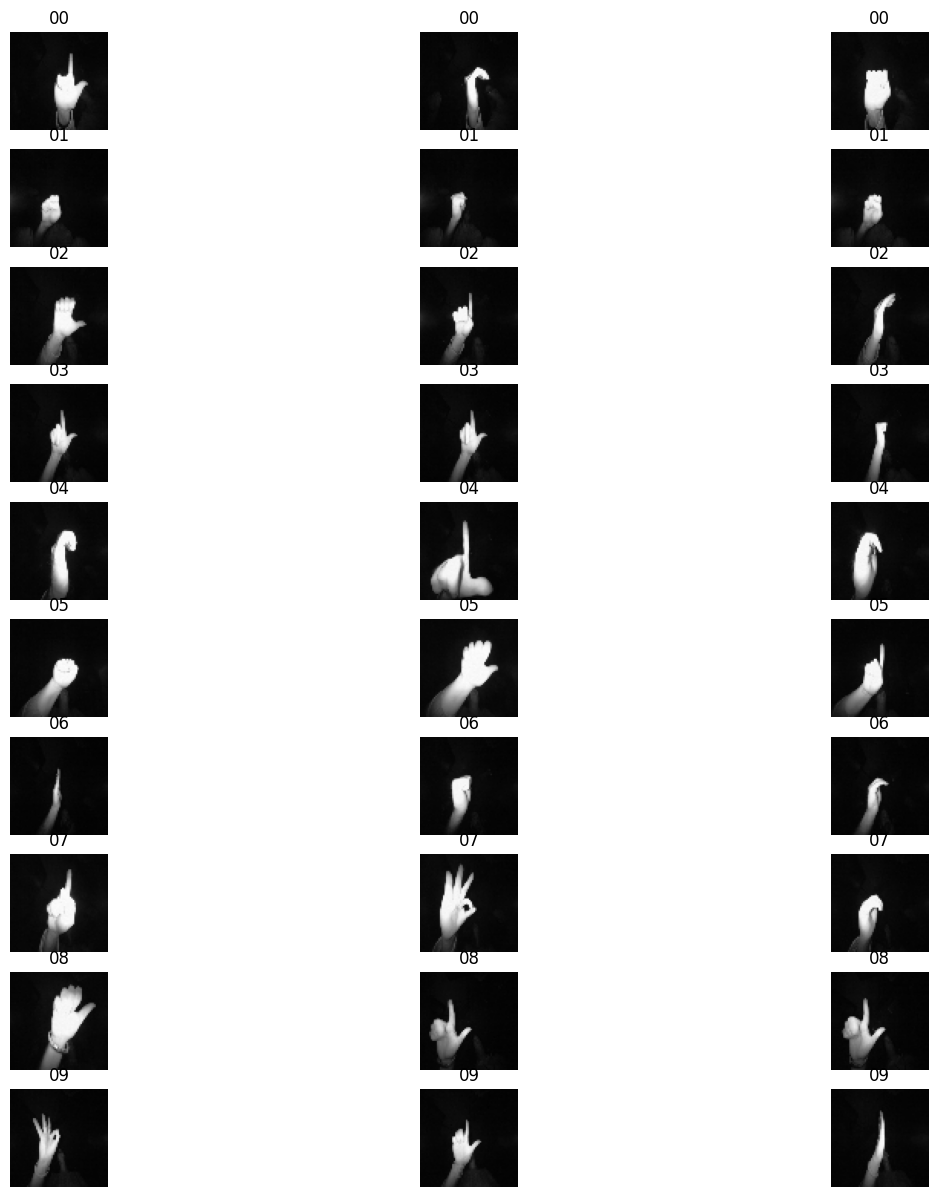

Image display completed.

Data analysis completed.



In [16]:
# Analyze Data: Count the total pictures inside each subfolder
def count_images_in_subfolders(root_path):
    """
    Counts the total number of images inside each subfolder and returns a dictionary.
    """
    print("Counting images in each subfolder...")
    image_count = defaultdict(int)

    for subdir, _, files in os.walk(root_path):
        if files:
            class_name = os.path.basename(subdir)
            image_count[class_name] = len([file for file in files if file.endswith('.png') or file.endswith('.jpg')])

    print("Image count in subfolders completed.\n")
    return image_count

# Check if images have fixed size
def check_image_sizes(root_path):
    """
    Checks the size of all images in the dataset to see if they have a fixed size.
    """
    print("Checking image sizes across subfolders...")
    image_sizes = defaultdict(set)

    for subdir, _, files in os.walk(root_path):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                image_path = os.path.join(subdir, file)
                img = cv2.imread(image_path)
                image_sizes[os.path.basename(subdir)].add(img.shape)

    print("Image size check completed.\n")
    return image_sizes

# Check image dtype
def check_image_dtype(root_path):
    """
    Checks the data type of the images in the dataset.
    """
    print("Checking image data types...")
    dtypes = set()

    for subdir, _, files in os.walk(root_path):
        for file in files:
            if file.endswith('.png') or file.endswith('.jpg'):
                image_path = os.path.join(subdir, file)
                img = cv2.imread(image_path)
                dtypes.add(img.dtype)

    print("Image dtype check completed.\n")
    return dtypes

# Display 3 random images from each class
def display_random_images_from_classes(root_path, num_images=3):
    """
    Displays random images from each class.
    """
    print(f"Displaying {num_images} random images from each class...")
    plt.figure(figsize=(15, 15))

    # Get subfolders (classes)
    class_folders = [f.path for f in os.scandir(root_path) if f.is_dir()]

    for i, class_folder in enumerate(class_folders):
        images = []
        # Recursively find images in all subfolders
        for subdir, _, files in os.walk(class_folder):
            for file in files:
                if file.endswith('.png') or file.endswith('.jpg'):
                    images.append(os.path.join(subdir, file))

        # Check if there are enough images to sample from
        if len(images) < num_images:
            print(f"Warning: Not enough images in {class_folder}. Only found {len(images)} images.")
            random_images = images  # Use all available images
        else:
            random_images = random.sample(images, num_images)  # Randomly pick images

        for j, img_path in enumerate(random_images):
            img = load_img(img_path, target_size=(64, 64))  # Resize for display
            img_array = img_to_array(img) / 255.0

            plt.subplot(len(class_folders), num_images, i * num_images + j + 1)
            plt.imshow(img_array)
            plt.title(os.path.basename(class_folder))
            plt.axis('off')

    plt.show()
    print("Image display completed.\n")

# Analyze and Display Data Information
print("Starting data analysis...\n")

image_counts = count_images_in_subfolders(data_path)
print("Image Counts in Each Subfolder (Class):")
for class_name, count in image_counts.items():
    print(f"{class_name}: {count} images")

image_sizes = check_image_sizes(data_path)
print("\nImage Sizes in Each Subfolder:")
for class_name, sizes in image_sizes.items():
    print(f"{class_name}: {sizes}")

dtypes = check_image_dtype(data_path)
print("\nImage Data Types:", dtypes)

# Display random images from each class
display_random_images_from_classes(data_path, num_images=3)

print("Data analysis completed.\n")

## Data Preprocessing

In [17]:
# Image data generators for loading and augmenting data
train_data_gen = ImageDataGenerator(
    rescale=1./255,            # Rescale pixel values to [0, 1]
    rotation_range=25,         # Rotate the image by 25 degrees max
    width_shift_range=0.2,     # Shift the image horizontally by 20% max
    height_shift_range=0.2,    # Shift the image vertically by 20% max
    shear_range=0.2,           # Apply shearing transformations
    zoom_range=0.2,            # Randomly zoom
    horizontal_flip=True,      # Randomly flip the images horizontally
    fill_mode='nearest',       # Fill any missing pixels
    validation_split=0.2       # Use 20% of the data for validation
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,            # Only rescaling for validation set
    validation_split=0.2       # 20% validation split
)

In [18]:
# Load training and validation data
train_generator = train_data_gen.flow_from_directory(
    directory='/content/drive/MyDrive/data/leapGestRecog',
    target_size=(128, 128),
    color_mode='grayscale',  # Ensure grayscale images
    class_mode='categorical',
    batch_size=16,
    subset='training',
    shuffle=True  # Shuffle data
)

validation_generator = valid_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/data/leapGestRecog',
    target_size=(128, 128),
    color_mode='grayscale',  # Ensure grayscale images
    class_mode='categorical',
    batch_size=16,
    subset='validation',
    shuffle=True
)


Found 16000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.


## Building a Convolutional Neural Network

In [19]:
# Define CNN model
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(128, 128, 1)))  # Grayscale has 1 channel
model.add(Activation('relu'))  # ReLU activation function
model.add(BatchNormalization())  # Normalize the activations to improve training
model.add(MaxPooling2D(pool_size=(2, 2)))  # Reduce spatial dimensions
model.add(Dropout(0.25))  # Dropout to prevent overfitting

# Second Convolutional Block
model.add(Conv2D(64, (5, 5), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten before the Fully Connected layers
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(256))  # 256 neurons in this fully connected layer
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output Layer (10 classes, one for each gesture)
model.add(Dense(10))  # 10 output classes for 10 gestures
model.add(Activation('softmax'))  # Softmax for multiclass classification

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),            # Adam optimizer
              loss='categorical_crossentropy',  # Loss function for multiclass classification
              metrics=['accuracy'])        # Monitor accuracy during training

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Training the model

In [20]:
# Define callbacks for early stopping and saving the best model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),  # Stop training when no improvement for 10 epochs
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)  # Save the best model
]

# Print some data from the validation generator to check
for data_batch, labels_batch in validation_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break  # Stop after one batch

# Train the model
history = model.fit(
    train_generator,
    epochs=50,                     # Number of epochs to train
    validation_data=validation_generator,
    callbacks=callbacks  # Use the callbacks defined earlier
)

Data batch shape: (16, 128, 128, 1)
Labels batch shape: (16, 10)
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2969 - loss: 2.4112
Epoch 1: val_loss improved from inf to 21.31277, saving model to best_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1566s 2s/step - accuracy: 0.2970 - loss: 2.4108 - val_accuracy: 0.1145 - val_loss: 21.3128
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5291 - loss: 1.3878
Epoch 2: val_loss improved from 21.31277 to 4.73297, saving model to best_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1578s 2s/step - accuracy: 0.5292 - loss: 1.3877 - val_accuracy: 0.2535 - val_loss: 4.7330
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6411 - loss: 1.0767
Epoch 3: val_loss improved from 4.73297 to 4.12108, saving model to best_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1580s 2s/step - accuracy: 0.6411 - loss: 1.0766 - val_accuracy: 0.3500 - val_loss: 4.1211
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7127 - loss: 0.8490
Epoch 4: val_loss did not improve from 4.12108

In [21]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 25,554,464 (97.48 MB)

 Trainable params: 8,517,834 (32.49 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 17,035,670 (64.99 MB)

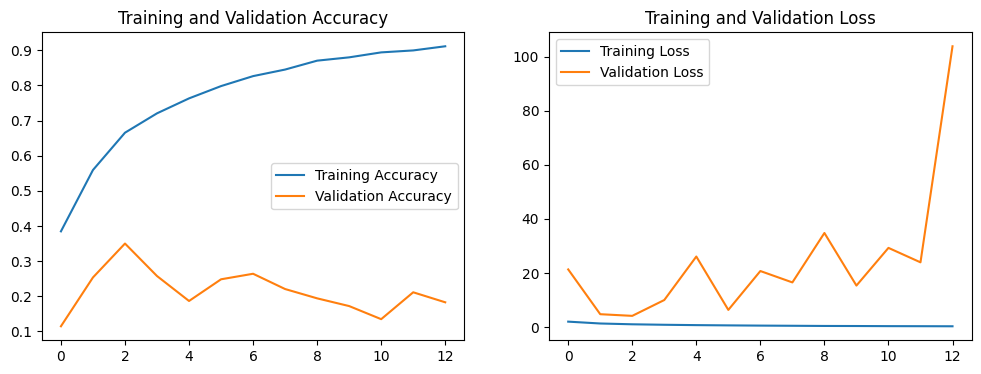

In [22]:
# Plot training & validation accuracy and loss
def plot_performance(history):
    # Accuracy Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_performance(history)

In [23]:
# Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_acc * 100:.2f}%')
print(f'Validation Loss: {val_loss:.4f}')

# Loading the best saved model (if required later)
best_model = tf.keras.models.load_model('best_model.keras')

# Test evaluation on a separate test dataset
# test_loss, test_acc = model.evaluate(test_generator)  # Assuming you have a separate test set loaded as `test_generator`
# print(f'Test Accuracy: {test_acc * 100:.2f}%')
# print(f'Test Loss: {test_loss:.4f}')

250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 340ms/step - accuracy: 0.3536 - loss: 4.1178
Validation Accuracy: 35.00%
Validation Loss: 4.1211
